In [112]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import community
from collections import Counter
import numpy as np


def parseDataset(path):
    df = pd.read_table(path, delimiter='\t', names=['source','target'])
    return nx.from_pandas_edgelist(df,"source","target")

def parseJson(path):
    with open(path) as f:
        data = json.load(f)
        return nx.node_link_graph(data)



In [ ]:
#Graph creation
dataset_path= "reducer/all_datas.json"
#G = parseDataset("dataset.txt")
#reduced = False
#has_foci= False
G= parseJson(dataset_path)
reduced = False
has_foci= True

In [ ]:
#generic analysis
print(G)


In [ ]:
#distances analysis (ci metterà una vita, la giant component richiederà ore)
if reduced:
    distances_sum = 0
    all_p = []
    connected_components_list = sorted(nx.connected_components(G), key=len, reverse=True)
    examined_components= 0
    for C in (G.subgraph(c).copy() for c in connected_components_list):
        p = dict(nx.shortest_path_length(C)) #questo conterrà tutte le distanze, per poter guardare max, min e media
        all_p.append(p)
        distance = nx.average_shortest_path_length(C)
        if distances_sum == 0:
            print("average path largest connected component= :" + str(distance))
        if distance > 0:
            examined_components += 1
            distances_sum += distance


    print("Average distance: ", distances_sum/examined_components)


In [ ]:
#clustering coefficient
print("Clustering coefficient: "+str(nx.average_clustering(G)))


Come si spiega questo valore? la discussione che abbiamo fatto di persona ( non ci sono grossi hubs, diciamo che le comunità sono degli hub). ciò si spiega anche con il discorso dei foci, abbiamo dei luogi in cui tantissime persone vanno.
ci sono ulteriori prove di ciò qui:
http://snap.stanford.edu/data/loc-brightkite.html
Si può notare che i triangoli chiusi sono pochissimi e quindi il clustering coefficient è basso.

In [ ]:
#largest connected component
print("Il grafo è connesso? "+str(nx.is_connected(G)))
print("Componenti connesse: "+ str(nx.number_connected_components(G)))
core_nodes = max(nx.connected_components(G), key=len)
print(f"largest connected component size: {len(core_nodes)}")
core = G.subgraph(core_nodes)
largest_component = G.subgraph(core_nodes).copy()

print([len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)])

In [ ]:
#degree analysis

def plot_degree_histogram(g, normalized=True):
    print("Creating histogram...")
    aux_y = nx.degree_histogram(g)

    aux_x = np.arange(0,len(aux_y)).tolist()

    n_nodes = g.number_of_nodes()

    if normalized:
        for i in range(len(aux_y)):
            aux_y[i] = aux_y[i]/n_nodes

    return aux_x, aux_y
    #codice copiato, dovrebbe restituire due liste, una con i valori dei gradi e una con la probabilità di avere tale grado

if not reduced:
    #tutto il grafo
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence grafo
    degree_sequence_lcc = sorted([d for n, d in largest_component.degree()], reverse=True)  # degree sequence largest connected component

    print("average degree: " + str(sum(degree_sequence)/len(degree_sequence)))
    print("average degree lcc: " + str(sum(degree_sequence_lcc)/len(degree_sequence_lcc)))

    print("number of nodes having 1 neighbour " + str(degree_sequence.count(min(degree_sequence))))
    print("number of nodes having 1 neighbour in lcc" +str(degree_sequence_lcc.count(min(degree_sequence_lcc))))
    print(degree_sequence.count(1) + degree_sequence.count(2) + degree_sequence.count(3) + degree_sequence.count(4))
    #ah, ecco perchè.
    print("minimum value of neighbour" + str(min(degree_sequence)))
    print("minimum value of neighbour in lcc" + str(min(degree_sequence_lcc)))

    plt.title('Degree distribution of the graph')
    plt.xlabel('Degree[log]')
    plt.ylabel('Number of Nodes[log]')
    plt.xscale("log")
    plt.yscale("log")
    aux_x, aux_y = plot_degree_histogram(G, normalized=True)
    plt.plot(aux_x,aux_y)

In [119]:
#Degree correlation
if not reduced:
    print("Degree correlation: "+str(nx.degree_pearson_correlation_coefficient(G)))
    print("Degree correlation: "+str(nx.degree_pearson_correlation_coefficient(largest_component)))

Degree correlation: 0.15331144700307117
Degree correlation: 0.12291294299635476


48
Counter({1: 547, 7: 498, 8: 492, 3: 466, 9: 416, 12: 369, 36: 311, 5: 237, 10: 223, 24: 193, 20: 167, 22: 160, 18: 151, 6: 137, 21: 132, 17: 121, 2: 118, 15: 114, 4: 103, 14: 99, 23: 67, 26: 52, 16: 49, 29: 45, 27: 34, 33: 33, 13: 26, 30: 23, 35: 19, 19: 17, 32: 15, 11: 13, 34: 11, 37: 8, 40: 7, 45: 7, 39: 6, 42: 6, 43: 6, 46: 6, 38: 5, 44: 5, 31: 4, 47: 4, 0: 4, 41: 4, 25: 4, 28: 4})


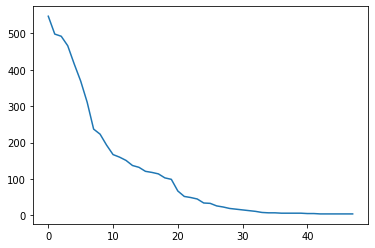

In [120]:
#community detection
communities = community.community_louvain.best_partition(G)
largest_component_communities = community.community_louvain.best_partition(largest_component)
# number of communities
#print(Counter(communities.values()))
print(len(Counter(largest_component_communities.values())))
print(Counter(largest_component_communities.values()))
plt.plot(sorted(Counter(largest_component_communities.values()).values(),reverse=True))



degree correlation: -0.5213436752724003


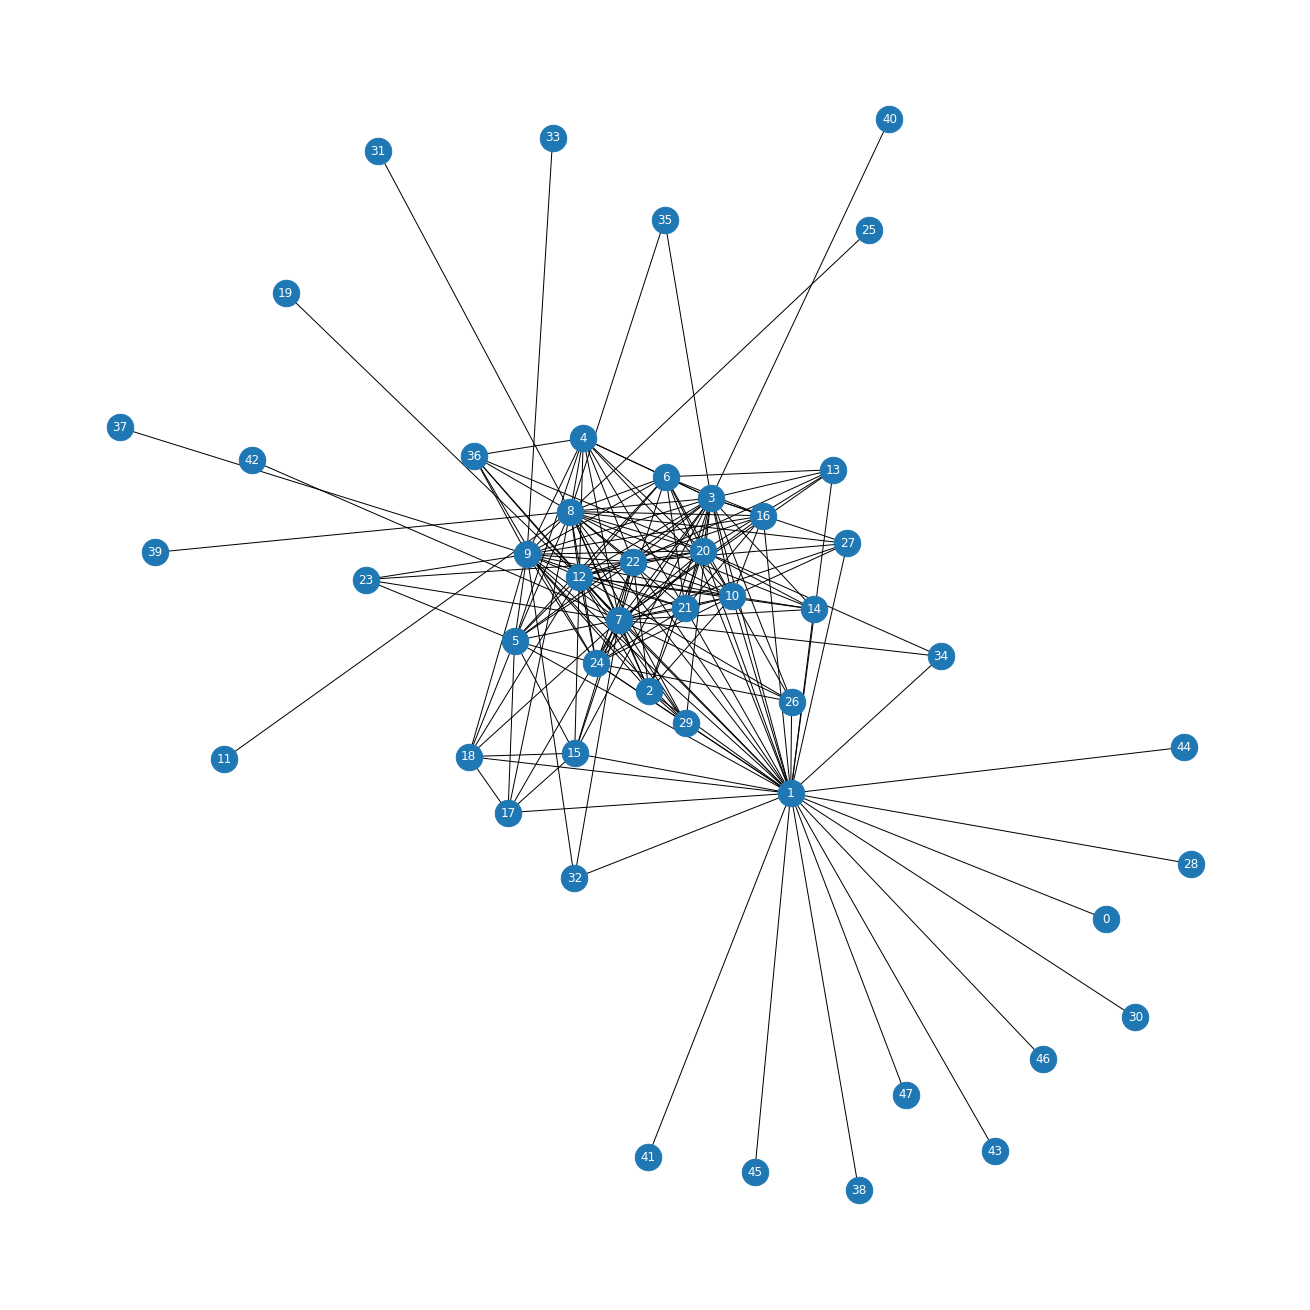

'si nota subito una grossa comunità centrale (la 1) ma è interessante anche notare che c\'è un cluster di comunità che fungono da "intermediari"\ntra le comunità di sinistra e quelle di destra. la 1 è assolutamente un hub (ed è la comunità più grossa),ma le altre nel mezzo permettono il collegamento.\n'

In [121]:
#TODO: aggiustare la dimensione dell'immagine, se si decommenta la linea precedente il grafo delle comunità diventa un amoung us
#per ignorare quelle da due è meglio valutare solo la largest_component
induced_graph = community.induced_graph(largest_component_communities, largest_component, weight='WEIGHT')
#induced_graph_all= community.induced_graph(communities, G, weight='WEIGHT')
induced_graph.remove_edges_from(nx.selfloop_edges(induced_graph))
#induced_graph.remove_edges_from(nx.selfloop_edges(induced_graph_all))
print("degree correlation: "+str(nx.degree_pearson_correlation_coefficient(induced_graph)))
#print("degree correlation: "+str(nx.degree_pearson_correlation_coefficient(induced_graph_all)))

plt.figure(figsize=(18,18))
nx.draw(induced_graph, with_labels=True, node_size=700,font_color="white")
plt.show()
'''si nota subito una grossa comunità centrale (la 1) ma è interessante anche notare che c'è un cluster di comunità che fungono da "intermediari"
tra le comunità di sinistra e quelle di destra. la 1 è assolutamente un hub (ed è la comunità più grossa),ma le altre nel mezzo permettono il collegamento.
'''

In [122]:
#centrality analysis
if reduced:
    print(nx.closeness_centrality(G))
else:
    print("betweenness centrality: "+str(sum(nx.betweenness_centrality(G,k=100).values())/58228))
    #troppo grande per fare closeness_centrality(G)

#sarebbe interessante valutare la betwenness di alcuni nodi particolari

betweenness centrality: 4.190633573002976e-06


Counter({3: 624, 1: 595, 7: 495, 9: 339, 13: 328, 20: 327, 0: 301, 8: 284, 22: 283, 19: 176, 24: 149, 6: 143, 17: 132, 12: 129, 16: 121, 14: 115, 21: 113, 5: 106, 31: 93, 10: 87, 29: 72, 4: 68, 2: 65, 30: 46, 35: 42, 15: 40, 25: 34, 27: 34, 34: 33, 28: 23, 36: 19, 18: 17, 11: 13, 33: 10, 37: 10, 40: 7, 43: 7, 39: 6, 41: 6, 44: 6, 45: 6, 38: 5, 42: 5, 32: 4, 46: 4, 47: 4, 48: 4, 26: 4, 23: 4})


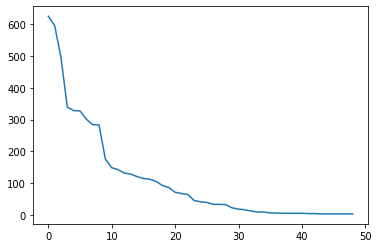

In [123]:
#community detection
#communities = community_louvain.best_partition(G)
largest_component_communities = community.community_louvain.best_partition(largest_component)
# number of communities
#print(Counter(communities.values()))
print(Counter(largest_component_communities.values()))
plt.plot(sorted(Counter(largest_component_communities.values()).values(),reverse=True))
#per ignorare quelle da due è meglio valutare solo la largest_component

In [124]:
#affiliation analysis (foci)
if has_foci:
    foci = {}
    links = list(G.edges(data=True))
    for link in links:
        if link[2]['position'] in foci:
            foci[link[2]['position']] += 1
        else:
            foci[link[2]['position']] = 1

    print(dict(sorted(foci.items(), key=lambda x: x[1], reverse=True)[0:20]))

#ci sono pochi luogi in cui va tantissima gente ( circa il 9%), in pratica il 30% delle persone ha visitato almeno uno di questi 4 posti.

{'ee8b1d0ea22411ddb074dbd65f1665cf': 2606, 'eefadd1aa22411ddb0fd7f1c9c809c0c': 1198, 'ee81ef22a22411ddb5e97f082c799f59': 1052, 'ede07eeea22411dda0ef53e233ec57ca': 890, '4aa5fa342e11deaf79003048c10834': 792, 'ee78cc1ca22411dd9b3d576115a846a7': 601, 'a307b2ae0edd11debb8f003048c10834': 565, 'a56253a4a22411dda7206be1bbffab43': 334, '8fbcb28fd5d11ddaf28003048c10834': 305, 'ed58942aa22411dd96ff97a15c29d430': 286, 'eb3aa69ca22411ddb5e613b206a5fc21': 284, 'b9c114f2a22411dda217eb3127033598': 279, 'd12e8e8aa22411dd90196fa5c210e3cc': 270, 'bd60fd9130532f56735fb38a2720594ac2baa5af': 208, 'eb14b798a22411ddbf103b9d66732c0a': 198, '118b01ec40111dda689003048c0801e': 194, 'ee81fddca22411dd93aeb7dc12ab591c': 183, '81da8d6f9e6b378e9522570064d443aad4c1d364': 179, 'ee24f45ca22411dd93d66fafb9e6ea64': 163, 'd1979aa6a22411ddba710b85db5ae7cb': 159}
